<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [79]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [80]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-06-21 06:02:00--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2022-06-21 06:02:00 (201 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [81]:
df = pd.read_csv('loan_train.csv')
df.head(3)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male


In [38]:
df.shape

(346, 10)

### Convert to date time object


In [82]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head(3)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [40]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [83]:
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [84]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

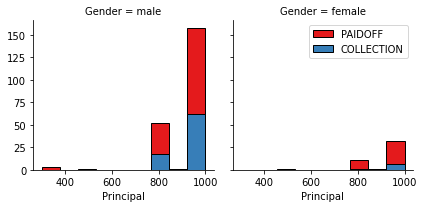

In [85]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

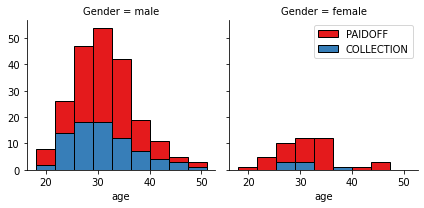

In [86]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

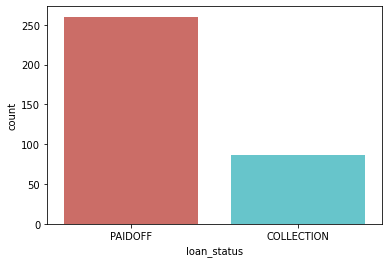

In [87]:
countplt=sns.countplot(x='loan_status', data=df, palette ='hls')

plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


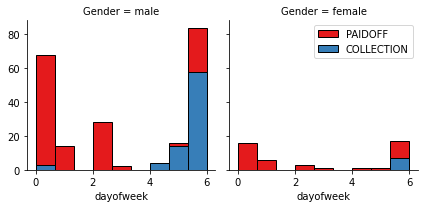

In [88]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [89]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head(4)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [90]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [91]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head(4)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1


## One Hot Encoding

#### How about education?


In [92]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [93]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [95]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#Feature.tail(20)
Feature.drop(['Master or Above'], axis = 1,inplace=True)# only two people with Master and above, so drop it 
#Feature.head(4)
#new_Feature = pd.concat([Feature, ]) 
print (type(Feature))

<class 'pandas.core.frame.DataFrame'>


### Feature Selection


Let's define feature sets, X:


In [96]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [97]:
df_n = df.loan_status.replace(to_replace=['PAIDOFF', 'COLLECTION'], value=[0,1])
print (df_n.head(3))
y = df_n.values
print ("labels type: ", type(y))
y[0:5]

0    0
1    0
2    0
Name: loan_status, dtype: int64
labels type:  <class 'numpy.ndarray'>


array([0, 0, 0, 0, 0])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [98]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [99]:
# split the data into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=30)
print ("Training features shape:", X_train.shape)
print ("test features shape: ", X_test.shape)
print ("training labels shape: ", Y_train.shape)

Training features shape: (259, 8)
test features shape:  (87, 8)
training labels shape:  (259,)


In [101]:
# import KNN 
from sklearn.neighbors import KNeighborsClassifier

In [102]:
kneighbor = KNeighborsClassifier(n_neighbors=7)
kneighbor.fit(X_train, Y_train)
y_hat = kneighbor.predict(X_test)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: di

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.7011494252873564, 0.7816091954022989, 0.7586206896551724, 0.8045977011494253, 0.7931034482758621, 0.8275862068965517, 0.8620689655172413, 0.8275862068965517, 0.8275862068965517] 
 [0.0490764  0.04429476 0.04587782 0.04251034 0.04342921 0.04049795
 0.0369694  0.04049795 0.04049795]
0.7982120051085568


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:907: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: di

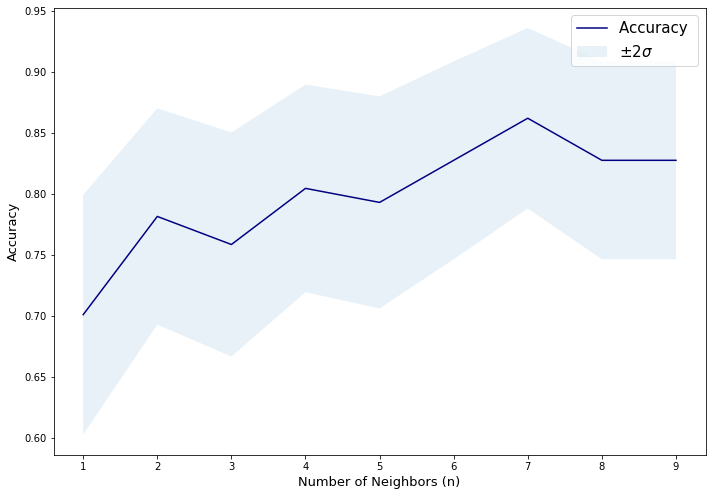

The best accuracy was with 0.8620689655172413 with neighbors (n) = 7


In [103]:
from sklearn import metrics

K_neigh = 10
mean_acc_test = []
std_acc = np.zeros((K_neigh-1))
print (std_acc)

for i in range(1,K_neigh):
    K_classf = KNeighborsClassifier(n_neighbors=i).fit(X_train, Y_train)
    Y_hat_KNN = K_classf.predict(X_test)
    mean_acc_test.append(metrics.jaccard_similarity_score(Y_test, Y_hat_KNN))
    std_acc[i-1]= np.std(Y_hat_KNN==Y_test) / np.sqrt(Y_hat_KNN.shape[0]) 
print (mean_acc_test, '\n', std_acc) # std better be a numpy array to use np.std  

m = sum(mean_acc_test)/len(mean_acc_test)
print (m)

fig=plt.figure(figsize=(10,7))
plt.plot(range(1,K_neigh),mean_acc_test,'navy')
plt.fill_between(range(1,K_neigh), mean_acc_test - 2 * std_acc, mean_acc_test + 2 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', r'$\pm 2\sigma $'), fontsize=15)
plt.ylabel('Accuracy', fontsize=13)
plt.xlabel('Number of Neighbors (n)', fontsize=13)
plt.tight_layout()
plt.show()

print ("The best accuracy was with", max(mean_acc_test), "with neighbors (n) =", np.argmax(mean_acc_test)+1)  

In [105]:
 # jaccard score and f1 score
print("Train set Accuracy (Jaccard): ", metrics.accuracy_score(Y_train, kneighbor.predict(X_train)))
print("Test set Accuracy (Jaccard): ", metrics.accuracy_score(Y_test, y_hat))

print("Train set Accuracy (F1): ", metrics.f1_score(Y_train, kneighbor.predict(X_train)))
print("Test set Accuracy (F1): ", metrics.f1_score(Y_test, y_hat))

Train set Accuracy (Jaccard):  0.7722007722007722
Test set Accuracy (Jaccard):  0.8620689655172413
Train set Accuracy (F1):  0.5426356589147286
Test set Accuracy (F1):  0.6


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < Loose

# Decision Tree


In [106]:
from sklearn.tree import DecisionTreeClassifier



In [107]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
loanTree.fit(X_train, Y_train)
y_hat_LTr = loanTree.predict(X_test)

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/tree/tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)


In [108]:
print("Train set Accuracy (Jaccard): ", metrics.jaccard_similarity_score(Y_train, loanTree.predict(X_train)))
print("Test set Accuracy (Jaccard): ", metrics.jaccard_similarity_score(Y_test, y_hat_LTr))

print("Train set Accuracy (F1): ", metrics.f1_score(Y_train, loanTree.predict(X_train)))
print("Test set Accuracy (F1): ", metrics.f1_score(Y_test, y_hat_LTr))

Train set Accuracy (Jaccard):  0.7837837837837838
Test set Accuracy (Jaccard):  0.735632183908046
Train set Accuracy (F1):  0.5483870967741935
Test set Accuracy (F1):  0.34285714285714286


# Support Vector Machine


In [109]:
# import svm 
from sklearn import svm
clf1 = svm.SVC(kernel='rbf', gamma=0.7)

In [110]:
# prediction part

clf1.fit(X_train, Y_train) 
y_hat_SVM = clf1.predict(X_test)

In [111]:
print("Train set Accuracy (Jaccard): ", metrics.jaccard_similarity_score(Y_train, clf1.predict(X_train)))
print("Test set Accuracy (Jaccard): ", metrics.jaccard_similarity_score(Y_test, y_hat_SVM))

print("Train set Accuracy (F1): ", metrics.f1_score(Y_train, clf1.predict(X_train)))
print("Test set Accuracy (F1): ", metrics.f1_score(Y_test, y_hat_SVM))

Train set Accuracy (Jaccard):  0.7876447876447876
Test set Accuracy (Jaccard):  0.7701149425287356
Train set Accuracy (F1):  0.4859813084112149
Test set Accuracy (F1):  0.16666666666666669


# Logistic Regression


In [112]:
# import logistic classifier
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train,Y_train)#libilinear is good for small data-set

In [113]:
y_hat_LR = LR.predict(X_test)

from sklearn.metrics import jaccard_similarity_score
print ("Jaccard score: ", jaccard_similarity_score(Y_test, y_hat_LR))

print("Train set Accuracy (F1): ", metrics.f1_score(Y_train, LR.predict(X_train)))
print("Test set Accuracy (F1): ", metrics.f1_score(Y_test, y_hat_LR))

Jaccard score:  0.8275862068965517
Train set Accuracy (F1):  0.41666666666666663
Test set Accuracy (F1):  0.4827586206896552


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

In [114]:
# log loss for logistic 
from sklearn.metrics import log_loss

y_hat_prob1_LR = LR.predict_proba(X_test)
print ("Log loss score: ", log_loss(Y_test, y_hat_prob1_LR))

Log loss score:  0.6679306006663686


# Model Evaluation using Test set


In [115]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [116]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-06-21 06:28:57--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0.02s   

2022-06-21 06:28:57 (188 KB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [117]:
test_df = pd.read_csv('loan_test.csv')
test_df.head(6)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male
5,37,37,PAIDOFF,700,15,9/11/2016,9/25/2016,33,High School or Below,male


In [118]:
# process the data set as before 

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek 
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True) # 0 for male and 1 for female
test_df.head(54)
print (test_df.dtypes)

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                     int64
dayofweek                  int64
weekend                    int64
dtype: object


In [119]:
feature_test = test_df[['Principal','terms','age','Gender','weekend']]
feature_test = pd.concat([feature_test,pd.get_dummies(test_df['education'])], axis=1)
feature_test.drop(['Master or Above'], axis = 1,inplace=True)
print (type(feature_test))



X_test_loan = feature_test
X_test_loan[0:5]

<class 'pandas.core.frame.DataFrame'>


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [120]:
test_df_n = test_df.loan_status.replace(to_replace=['PAIDOFF', 'COLLECTION'], value=[0,1])
print (test_df_n.head(3))
y_test_loan = test_df_n.values
print ("labels type: ", type(y_test_loan))
y_test_loan[0:5]

0    0
1    0
2    0
Name: loan_status, dtype: int64
labels type:  <class 'numpy.ndarray'>


array([0, 0, 0, 0, 0])

In [121]:
X_test_loan= preprocessing.StandardScaler().fit(X_test_loan).transform(X_test_loan)
X_test_loan[0:5]
print (type(X_test_loan))
print ("shape of loan test data: ", X_test_loan.shape)
#print (X_test_loan.shape, y_test_loan.shape)

<class 'numpy.ndarray'>
shape of loan test data:  (54, 8)


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


##K Nearest neighour

In [123]:
#kneighbor1 = KNeighborsClassifier(n_neighbors=7)
#kneighbor1.fit(X_train, Y_train)

y1_hat = kneighbor.predict(X_test_loan)

print("Test data-set Accuracy (Jaccard): ", metrics.jaccard_similarity_score(y_test_loan, y1_hat))
print("Test set Accuracy (F1): ", metrics.f1_score(y_test_loan, y1_hat))

Test data-set Accuracy (Jaccard):  0.7037037037037037
Test set Accuracy (F1):  0.3333333333333333


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/neighbors/base.py:442: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')


Descion tree

In [124]:
#loanTree1 = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
#loanTree1.fit(X_train, Y_train)
y1_hat_LTr = loanTree.predict(X_test_loan)


print("Test data-set Accuracy (Jaccard): ", metrics.jaccard_similarity_score(y_test_loan, y1_hat_LTr))
print("Test set Accuracy (F1): ", metrics.f1_score(y_test_loan, y1_hat_LTr))

Test data-set Accuracy (Jaccard):  0.8148148148148148
Test set Accuracy (F1):  0.5454545454545454


SVM

In [127]:
#clf2 = svm.SVC(kernel='rbf', gamma=0.1)
#clf2.fit(X_train, Y_train) 
y1_hat_SVM = clf1.predict(X_test_loan)

print("Test data-set Accuracy (Jaccard): ", metrics.jaccard_similarity_score(y_test_loan, y1_hat_SVM))
print("Test set Accuracy (F1): ", metrics.f1_score(y_test_loan, y1_hat_SVM))

Test data-set Accuracy (Jaccard):  0.7222222222222222
Test set Accuracy (F1):  0.2857142857142857


In [ ]:
Logistic Regression

In [128]:
y1_hat_LR = LR.predict(X_test_loan)

y1_hat_prob1_LR = LR.predict_proba(X_test_loan)

print ("Test data-set Accuracy (Jaccard): ", jaccard_similarity_score(y_test_loan, y1_hat_LR))
print("Test set Accuracy (F1): ", metrics.f1_score(y_test_loan, y1_hat_LR))
print ("Log loss score: ", log_loss(y_test_loan, y1_hat_prob1_LR))

Test data-set Accuracy (Jaccard):  0.7777777777777778
Test set Accuracy (F1):  0.4
Log loss score:  0.671749679111244


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


In [ ]:
# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                |0.703    |0.333     | NA      |
| Decision Tree      |0.815    |0.545     | NA      |
| SVM                |0.722    | 0.286    | NA      |
| LogisticRegression |0.778    |0.40      |0.672    |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
